In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import shutil
import glob
from scipy import sparse
from sklearn.linear_model import LogisticRegression

np.random.seed(1)

In [2]:
# randomly generate data 
N = 3 # number of training sample 
d = 2 # data dimension 
C = 3 # number of classes 

X = np.random.randn(d, N)
y = np.random.randint(0, 3, (N,))

In [3]:
# One-hot encoding
def convert_labels(y, C=C):
    """
    convert 1d label to a matrix label: each column of this 
    matrix coresponding to 1 element in y. In i-th column of Y, 
    only one non-zeros element located in the y[i]-th position, 
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

            [[1, 0, 0, 1],
             [0, 0, 1, 0],
             [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y 

Y = convert_labels(y)

In [4]:
def softmax_stable(X):
    X_exp = np.exp(X - np.max(X, axis=0, keepdims=True))
    return X_exp / np.sum(X_exp, axis=0)

def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def grad(X, Y, W):
    A = softmax(W.T.dot(X))
    E = A - Y
    return X.dot(E.T)

def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

def numerical_grad(X, Y, W, cost):
    eps = 1e-6
    g = np.zeros_like(W)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_p = W.copy()
            W_n = W.copy()
            W_p[i, j] += eps 
            W_n[i, j] -= eps
            g[i,j] = (cost(X, Y, W_p) - cost(X, Y, W_n))/(2*eps)
    return g 

W_init = np.random.rand(d, C)

#g1 = grad(X, Y, W_init)
#g2 = numerical_grad(X, Y, W_init, cost)

#print(np.linalg.norm(g1 - g2))

In [5]:

def pred(W, X):
    return np.argmax(softmax_stable(W.T.dot(X)), axis=0)

## Generating data

In [6]:
# Creating data
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

# each column is a datapoint
X = np.concatenate((X0, X1, X2), axis = 0).T 
# extended data
X = np.concatenate((np.ones((1, 3*N)), X), axis = 0)
C = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T

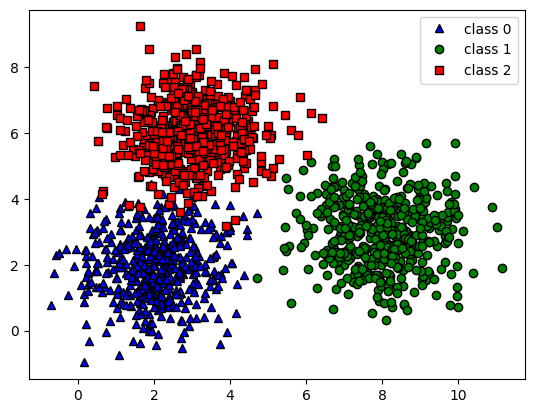

In [7]:
fig = plt.figure()
plt.plot(X0[:, 0], X0[:, 1], 'b^', markeredgecolor='black', label='class 0')
plt.plot(X1[:, 0], X1[:, 1], 'go', markeredgecolor='black', label='class 1')
plt.plot(X2[:, 0], X2[:, 1], 'rs', markeredgecolor='black', label='class 2')
plt.legend()
plt.show()

## Using softmax by sklearn

In [12]:
X_train = X[1:, :]
X_train = X_train.T
y_train = original_label

print(X_train.shape)
print(y_train.shape)

(1500, 2)
(1500,)


In [15]:
# Create a logistic regression model for multi-class classification
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the model on the training data
model.fit(X_train, y_train)

# Access the learned coefficients (weights) and intercept for each class
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients (weights):", coefficients)
print("Intercepts:", intercept)

Coefficients (weights): [[-1.54542258 -1.57699344]
 [ 2.57133938 -0.94387289]
 [-1.0259168   2.52086634]]
Intercepts: [13.04159099 -8.32230391 -4.71928708]


In [24]:
print(coefficients[1] - coefficients[2])
print(intercept[1] - intercept[2])

[ 3.59725618 -3.46473923]
-3.603016826411502


In [10]:
xx = np.linspace(np.min(X_train[:, 0]) - 1, np.max(X_train[:, 0]) + 1, 1000)
yy = np.linspace(np.min(X_train[: , 1]) - 1, np.max(X_train[:, 1]) + 1, 1000)
xx, yy = np.meshgrid(xx, yy)
data = np.array([xx.flatten(), yy.flatten()]).T

data_clusters =[X0, X1, X2]
cls_centroids = [np.mean(X0, axis=0), np.mean(X1, axis=0), np.mean(X2, axis=0)]
labels = ['class 0', 'class 1', 'class 2']
colors = ['b', 'g', 'r']
shapes = ['^', 'o', 's']
calc_linear_func = lambda x, coefs, intercept: np.round(np.dot(x, coefs) + intercept, 1)

def plot_data_points(data_clusters, colors, shapes):
    plt.axis([data[0, 0], data[-1, 0], data[0, 1], data[-1, 1]])
    for i, data_cluster in enumerate(data_clusters):
        plt.plot(data_cluster[:, 0], data_cluster[:, 1], '{}{}'.format(colors[i], shapes[i]), markeredgecolor='black', label='class {}'.format(i))
    return plt

def find_intersection_index(x, coefs, intercept):
    intersection_point = calc_linear_func(x, coefs, intercept)
    intersection_index = np.where(intersection_point == 0)[0][0]
    return intersection_index

def find_min_distance_arg(points, centroid):
    return np.argmin([np.linalg.norm(point - centroid) for point in points])

def plot_boundary_and_area(plt, boundary, area, color):
    plt.plot(boundary[:, 0], boundary[:, 1], color=color, alpha=0.5)
    if area is not None:
        plt.plot(area[:, 0], area[:, 1], color=color, alpha=0.2)
    return plt

def find_boundaries(weight_list, cls_centroid, C=3):
    linear_rs = [calc_linear_func(data, coefs.T, intercept) for coefs, intercept in weight_list]
    lines = [data[...][linear == 0] for linear in linear_rs]

    line_list = []
    for line, (coefs, intercept) in zip(lines, weight_list[::-1]):
        intersection_index = find_intersection_index(line, coefs, intercept)
        line_range = [line[:intersection_index, :], line[intersection_index:, :]]
        points = [line[line.shape[0] // 2, :] for line in line_range]
        best_line = line_range[find_min_distance_arg(points, cls_centroid)]
        line_list.append(best_line)

    boundary = np.concatenate(line_list, axis=0)

    return boundary

def find_area(weight_list):
    linear_rs = [calc_linear_func(data, coefs.T, intercept) for coefs, intercept in weight_list]

    inside_boundary = np.ones(linear_rs[0].shape[0])
    for linear in linear_rs:
        inside_boundary = np.logical_and(inside_boundary, linear >= 0)
    cls_area = data[inside_boundary, :]
    return cls_area

def draw_decision_boundaries(data_clusters, colors, shapes, cls_centroids, coef_matrix=coefficients, intercept_vector=intercept, C=3):
    plt = plot_data_points(data_clusters, colors, shapes)
    for i in range(C):
        weight_list = []
        for j in range(C):
            if j == i:
                continue
            coefs, intercept = coef_matrix[i, :] - coef_matrix[j, :], intercept_vector[i] - intercept_vector[j]
            weight_list.append((coefs, intercept))

        cls_boundary = find_boundaries(weight_list, cls_centroids[i] , C)
        cls_area = find_area(weight_list)
        plot_boundary_and_area(plt, cls_boundary, cls_area, colors[i])

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary for Binary Classification')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show

#draw_decision_boundaries(data_clusters, colors, shapes, cls_centroids, coefficients, intercept)

## Using our model

In [8]:
calc_linear_func = lambda x, weights: np.round(np.dot(x, weights), 1)
xx = np.linspace(np.min(X[1, :]) - 1, np.max(X[1, :]) + 1, 1000)
yy = np.linspace(np.min(X[2, :]) - 1, np.max(X[2, :]) + 1, 1000)
xx, yy = np.meshgrid(xx, yy)
data = np.vstack([np.ones(xx.flatten().shape[0]), xx.flatten(), yy.flatten()]).T

data_clusters =[X0, X1, X2]
cls_centroids = [np.mean(X0, axis=0), np.mean(X1, axis=0), np.mean(X2, axis=0)]
labels = ['class 0', 'class 1', 'class 2']
colors = ['b', 'g', 'r']
shapes = ['^', 'o', 's']

def plot_data_points(x_y_limits):
    plt.axis(x_y_limits)
    for i, data_cluster in enumerate(data_clusters):
        plt.plot(data_cluster[:, 0], data_cluster[:, 1], '{}{}'.format(colors[i], shapes[i]), markeredgecolor='black', label='class {}'.format(i))
    return plt

def plot_area(plt, area, color):
    if area is not None:
        plt.plot(area[:, 0], area[:, 1], color=color, alpha=0.2)
    return plt

def find_area(weight_list):
    linear_rs = [calc_linear_func(data, weight) for weight in weight_list]
    inside_boundary = np.ones(linear_rs[0].shape[0])
    for linear in linear_rs:
        inside_boundary = np.logical_and(inside_boundary, linear >= 0)
    cls_area = data[inside_boundary, 1:]
    return cls_area

def draw_decision_boundaries(weight_matrix, frame_name, iteration, is_save):
    x_y_limits = [np.min(data[:, 1]), np.max(data[:, 1]), np.min(data[:, 2]), np.max(data[:, 2])]
    fig = plt.figure(figsize=(6, 5))
    plot = plot_data_points(x_y_limits)
    for i in range(C):
        weight_list = []
        for j in range(C):
            if j == i:
                continue
            weights = weight_matrix[i, :] - weight_matrix[j, :]
            weight_list.append(weights)

        cls_area = find_area(weight_list)
        plot_area(plot, cls_area, colors[i])

    plot.xlabel('Feature 1')
    plot.ylabel('Feature 2')
    plot.title('Iteration: {}'.format(iteration))
    #plot.legend(loc='upper right')
    #plot.legend()
    if is_save:
        plot.savefig(frame_name)
        plot.close()
    else:
        plot.show()

#draw_decision_boundaries(W[-1].T)

In [12]:
!rm -rf softmax_frames

In [13]:
def softmax_regression(X, y, W_init, learning_rate=.05, tol=1e-4, epochs=10000, save_frame=True):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N, d = X.shape[1], X.shape[0]

    cnt = 0

    count = 0
    check_w_after = 20
    while count < epochs:
        # mix data
        mix_id = np.random.permutation(N)
        for i in mix_id:

            if count == 700:
                learning_rate = .01
            
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] - learning_rate * xi.dot((ai - yi).T)
            count += 1
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
            cnt += 1
            if cnt == 3 and save_frame:
                draw_decision_boundaries(W[-1].T, './softmax_frames/frame_{}.jpg'.format(count), count, save_frame)
                cnt == 0
    return W

In [135]:
W_init = np.random.rand(X.shape[0], C)
W = softmax_regression(X, original_label, W_init, learning_rate=0.05, epochs=3000, save_frame=False)

NameError: name 'softmax_regression' is not defined

In [15]:
def create_gif(img_dir, output_file, duration=500):
    # List of image filenames
    image_files = os.listdir(img_dir)
    image_files = sorted(image_files, key=lambda filename: int(filename.split('_')[1].split('.')[0]))
    image_paths = [os.path.join(img_dir, img_file) for img_file in image_files]
    # Open the first image to get its size
    first_image = Image.open(image_paths[0])
    size = first_image.size
    images = []

    try:
        for img in image_paths:
            images.append(Image.open(img))
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    # Create a GIF file
    with Image.new('RGB', size) as gif:
        gif.save(output_file, save_all=True, append_images=images, duration=duration, loop=0)

    #shutil.rmtree(img_dir)

#create_gif('./softmax_frames', './softmax_illustration.gif', duration=200)

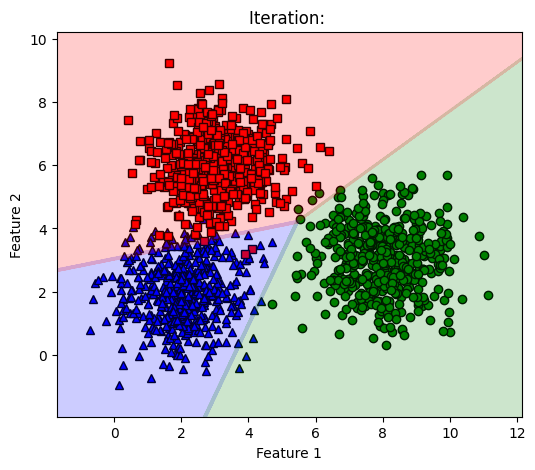

In [16]:
draw_decision_boundaries(W[-1].T, '', '', False)

In [134]:
print(W[-1])

NameError: name 'W' is not defined

In [82]:
xm = np.arange(-2, 11, 0.025)
xlen = len(xm)
ym = np.arange(-3, 10, 0.025)
ylen = len(ym)
xx, yy = np.meshgrid(xm, ym)


# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# xx.ravel(), yy.ravel()

print(np.ones((1, xx.size)).shape)
xx1 = xx.ravel().reshape(1, xx.size)
yy1 = yy.ravel().reshape(1, yy.size)

# print(xx.shape, yy.shape)
XX = np.concatenate((np.ones((1, xx.size)), xx1, yy1), axis = 0)


print(XX.shape)

Z = pred(W[-1], XX)

(1, 270400)
(3, 270400)


array([[ 2.08487567, -0.51489217,  3.02797697, ...,  3.53146569,
         1.28031549,  4.32660328],
       [ 3.34528451,  1.99485308,  2.64648818, ...,  7.78339888,
         5.331965  ,  5.27100351]])

array([0, 0, 0, ..., 2, 2, 2])

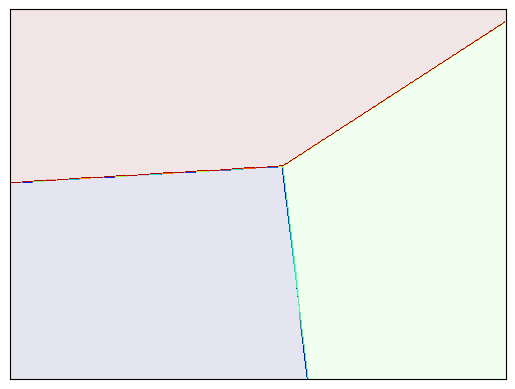

In [83]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
# plt.figure(1
# plt.pcolormesh(xx, yy, Z, cmap='jet', alpha = .35)

CS = plt.contourf(xx, yy, Z, 200, cmap='jet', alpha = .1)

# Plot also the training points
# plt.scatter(X[:, 1], X[:, 2], c=Y, edgecolors='k', cmap=plt.cm.Paired)
# plt.xlabel('Sepal length')
# plt.ylabel('Sepal width')

plt.xlim(-2, 11)
plt.ylim(-3, 10)
plt.xticks(())
plt.yticks(())
# plt.axis('equal')
display(X[1:, :], original_label)
plt.savefig('ex1.png', bbox_inches='tight', dpi = 300)
plt.show()

## Reference
https://machinelearningcoban.com/2017/02/17/softmax/